In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
def load_data(path="anime.xlsx"):
    data = pd.read_excel(path, sheet_name="anime")
    data.columns = [col.strip().replace(" ", "_") for col in data.columns]

    # Fix names
    data['name'] = data['name'].astype(str).apply(lambda x: re.sub(r"'", "'", x))

    # Handle genres
    genre_cols = ['genre.1', 'genre.2', 'genre.3', 'genre.4']
    for col in genre_cols:
        data[col] = data[col].fillna('')

    # Create genre set
    genre_set = set()
    for col in genre_cols:
        genre_set.update(data[col].unique())
    genre_set.discard('')

    # Clean genre names
    clean_genres = sorted({genre.strip().lower() for genre in genre_set})

    # Build genre matrix
    genre_matrix = pd.DataFrame(index=data.index)

    for clean_genre in clean_genres:
        genre_matrix[clean_genre] = data[genre_cols].apply(
            lambda x: int(clean_genre in [i.strip().lower() for i in x.values]), axis=1
        )

    # Append genre matrix all at once
    data = pd.concat([data, genre_matrix], axis=1)

    # Convert columns to numeric
    data['episodes'] = pd.to_numeric(data['episodes'], errors='coerce').fillna(data['episodes'].median())
    data['rating'] = pd.to_numeric(data['rating'], errors='coerce').fillna(data['rating'].median())
    data['members'] = pd.to_numeric(data['members'], errors='coerce').fillna(data['members'].median())

    # Popularity buckets
    q1, q2 = data['rating'].quantile([0.33, 0.66])
    data['PopularityLevel'] = pd.cut(data['rating'], 
                                    bins=[-1, q1, q2, float('inf')],
                                    labels=["Low Rated", "Moderately Rated", "Highly Rated"])

    # Scale features
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data[['rating', 'episodes', 'members']])
    scaled_df = pd.DataFrame(scaled, columns=['rating_scaled', 'episodes_scaled', 'members_scaled'])
    data = pd.concat([data, scaled_df], axis=1)

    return data, clean_genres

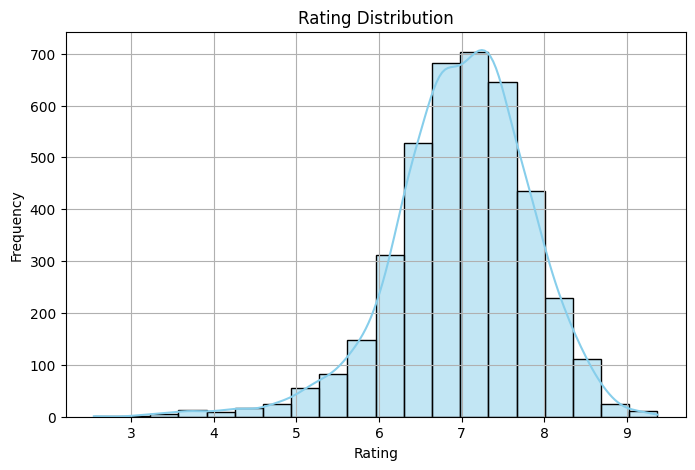

In [9]:
# Load data
data, genres = load_data()

# Rating Distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['rating'], bins=20, kde=True, color='skyblue')
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_13804\198423936.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="type", y="rating", palette="pastel")


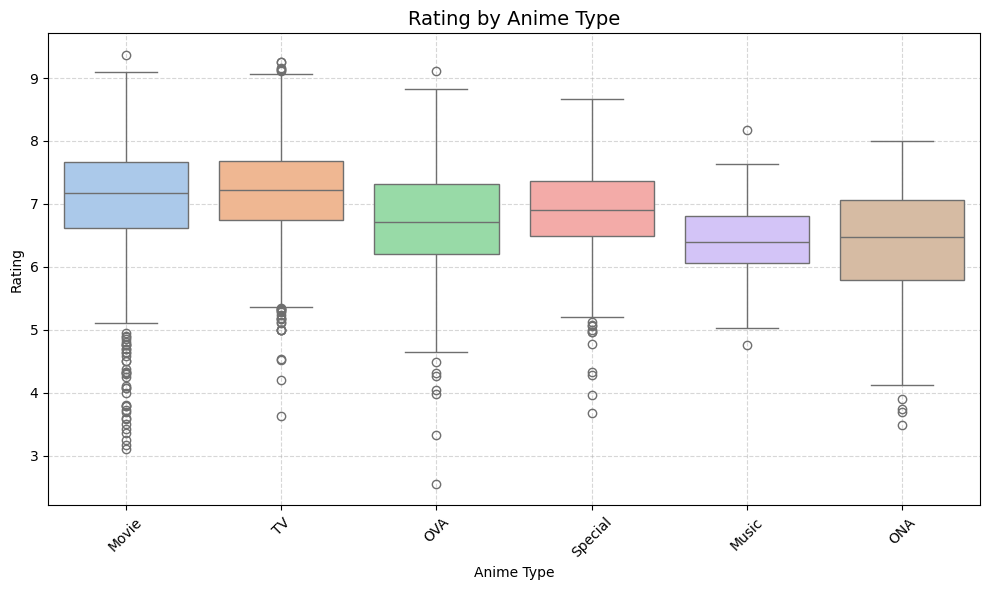

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x="type", y="rating", palette="pastel")
plt.title("Rating by Anime Type", fontsize=14)
plt.xlabel("Anime Type")
plt.ylabel("Rating")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_13804\527439004.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="PopularityLevel", y="rating", palette="Set2")


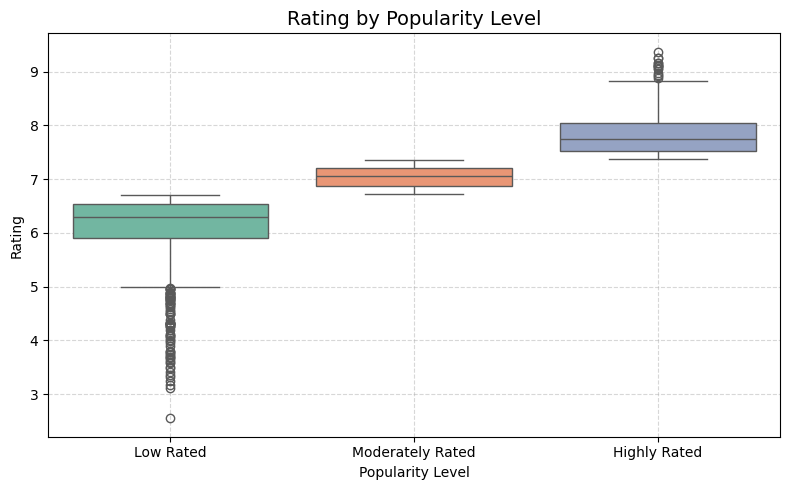

In [11]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x="PopularityLevel", y="rating", palette="Set2")
plt.title("Rating by Popularity Level", fontsize=14)
plt.xlabel("Popularity Level")
plt.ylabel("Rating")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


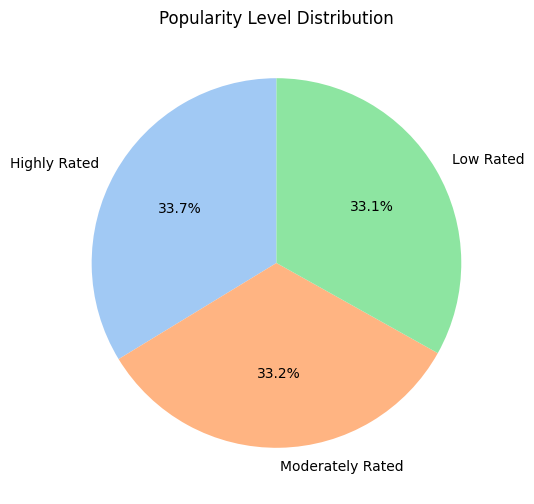

In [13]:
# Load data (ensure this is run before plotting)
data, genres = load_data()  
# Pie chart for PopularityLevel distribution
plt.figure(figsize=(6, 6))
data['PopularityLevel'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    startangle=90, 
    colors=sns.color_palette('pastel')
)
plt.title("Popularity Level Distribution")
plt.ylabel("")  # Remove y-label for cleaner pie chart
plt.show()

In [14]:
def train_model(data, genre_list):
    # Exclude 'rating_scaled' to avoid leakage
    all_features = ['episodes_scaled', 'members_scaled','members_scaled'] + genre_list
    features_to_use = [f for f in all_features if f != 'rating_scaled']  # Filter out rating_scaled

    X = data[features_to_use]
    y = data['PopularityLevel']
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42
    )
    
    model = GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    
    # Return the necessary variables, including features_to_use as feature_cols
    return model, X_test, y_test, y_pred, report, cm, features_to_use, le

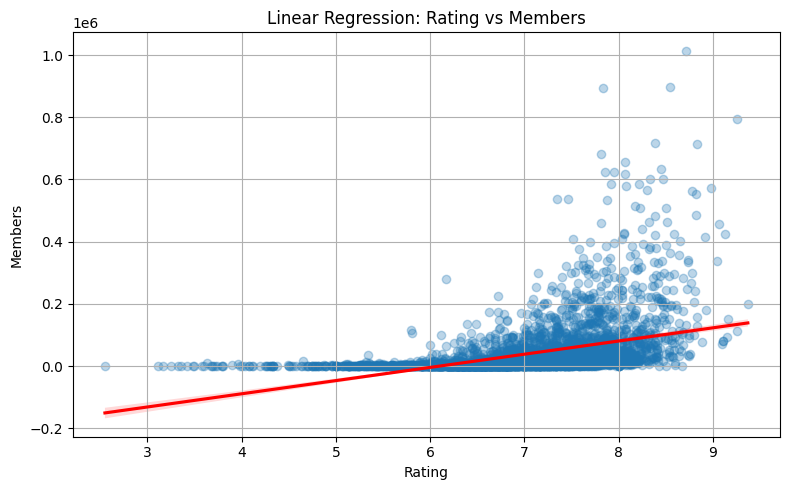

In [15]:
plt.figure(figsize=(8, 5))
sns.regplot(data=data, x="rating", y="members", scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.title("Linear Regression: Rating vs Members")
plt.xlabel("Rating")
plt.ylabel("Members")
plt.grid(True)
plt.tight_layout()
plt.show()


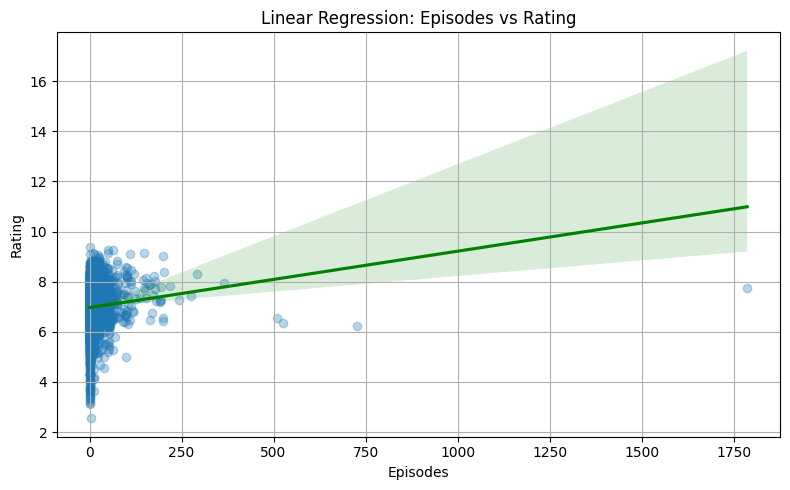

In [16]:
# Regression plot: Episodes vs Rating
plt.figure(figsize=(8, 5))
sns.regplot(data=data, x="episodes", y="rating", scatter_kws={'alpha': 0.3}, line_kws={'color': 'green'})
plt.title("Linear Regression: Episodes vs Rating")
plt.xlabel("Episodes")
plt.ylabel("Rating")
plt.grid(True)
plt.tight_layout()
plt.show()

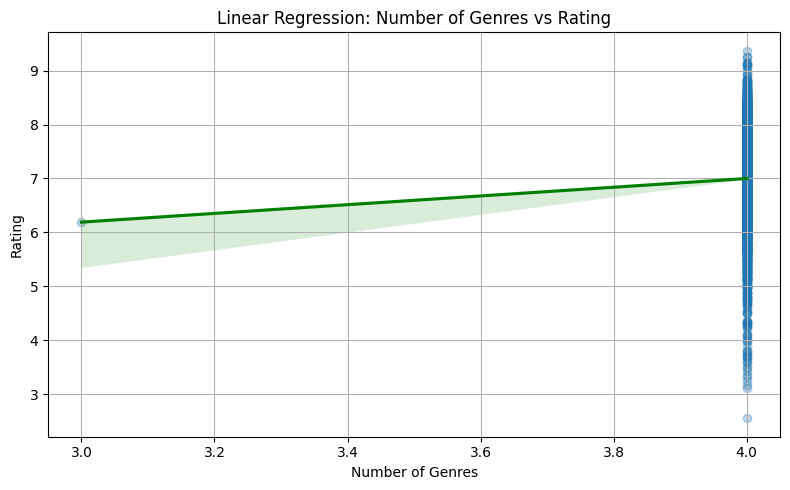

In [17]:
# Calculate number of genres per anime
data['num_genres'] = data[genres].sum(axis=1)

# Regression plot: Number of Genres vs Rating
plt.figure(figsize=(8, 5))
sns.regplot(data=data, x="num_genres", y="rating", scatter_kws={'alpha': 0.3}, line_kws={'color': 'green'})
plt.title("Linear Regression: Number of Genres vs Rating")
plt.xlabel("Number of Genres")
plt.ylabel("Rating")
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
try:
    model, X_test, y_test, y_pred, report, cm, features, le = train_model(data, genres)
except Exception as e:
    print(f"Error training model: {e}")
    raise

# Accuracy
print("Accuracy:", round(report['accuracy'] * 100, 2), "%")

# Classification Report
display(pd.DataFrame(report).T.style.background_gradient(cmap='YlGnBu'))

Accuracy: 63.12 %


,precision,recall,f1-score,support
Highly Rated,0.712177,0.709559,0.710866,272.000000
Low Rated,0.695167,0.697761,0.696462,268.000000
Moderately Rated,0.485075,0.485075,0.485075,268.000000
accuracy,0.631188,0.631188,0.631188,0.631188
macro avg,0.630806,0.630798,0.630801,808.000000
weighted avg,0.631209,0.631188,0.631197,808.000000


In [19]:
wrong = X_test[y_test != y_pred]
print("Misclassified Examples:")
print(wrong.head())

Misclassified Examples:
      episodes_scaled  members_scaled  members_scaled  action  adventure  \
2826        -0.075920       -0.338687       -0.338687       0          0   
3945        -0.351922       -0.434393       -0.434393       0          0   
2326        -0.301740       -0.456296       -0.456296       1          0   
1865         0.275356        0.467476        0.467476       0          0   
3965        -0.351922       -0.383977       -0.383977       0          0   

      cars  comedy  dementia  demons  drama  ...  shounen ai  slice of life  \
2826     0       1         0       0      0  ...           0              0   
3945     0       0         0       1      0  ...           0              0   
2326     0       0         0       0      0  ...           0              0   
1865     0       1         0       0      0  ...           0              0   
3965     0       0         0       0      1  ...           0              0   

      space  sports  super power  supernatur

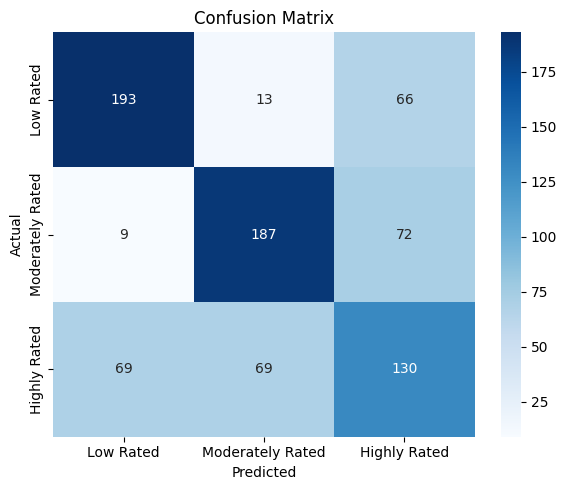

In [20]:
# Heatmap: Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low Rated", "Moderately Rated", "Highly Rated"],
            yticklabels=["Low Rated", "Moderately Rated", "Highly Rated"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [22]:
def get_recommendations(anime_name, df, genre_list, top_n=5, include_rating=False):
   
    # Define features, excluding 'rating_scaled' by default to avoid leakage
    all_features = ['episodes_scaled', 'members_scaled'] + genre_list
    if include_rating:
        all_features = ['rating_scaled'] + all_features
    
    # Validate feature columns
    missing_cols = [col for col in all_features if col not in df.columns]
    if missing_cols:
        return pd.DataFrame({"Error": [f"Missing columns: {', '.join(missing_cols)}"]})
    
    # Create feature matrix
    feature_matrix = df[all_features]
    
    # Handle missing or invalid data
    if feature_matrix.isnull().any().any():
        return pd.DataFrame({"Error": ["Feature matrix contains missing values."]})
    
    # Compute cosine similarity
    try:
        similarity = cosine_similarity(feature_matrix)
    except Exception as e:
        return pd.DataFrame({"Error": [f"Error computing similarity: {str(e)}"]})
    
    # Find the index of the input anime
    try:
        idx = df[df['name'] == anime_name].index[0]
    except IndexError:
        return pd.DataFrame({"Error": [f"Anime '{anime_name}' not found."]})
    
    # Get similarity scores and sort
    scores = list(enumerate(similarity[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    top_indices = [i[0] for i in scores[1:top_n+1]]
    top_scores = [i[1] for i in scores[1:top_n+1]]
    
    # Create output DataFrame
    recommendations = df.iloc[top_indices][['name', 'type', 'rating', 'PopularityLevel']].copy()
    recommendations['SimilarityScore'] = top_scores
    recommendations = recommendations.reset_index(drop=True)
    
    return recommendations

In [23]:
sample_anime = data['name'].iloc[0]
print(f"Top 5 recommendations similar to '{sample_anime}':")
get_recommendations(sample_anime, data, genres)


Top 5 recommendations similar to 'Kimi no Na wa.':


,name,type,rating,PopularityLevel,SimilarityScore
0,School Days,TV,6.17,Low Rated,0.877971
1,Ao Haru Ride,TV,7.89,Highly Rated,0.877542
2,Kokoro Connect,TV,8.01,Highly Rated,0.876765
3,Yahari Ore no Seishun Love Comedy wa Machigatt...,TV,8.31,Highly Rated,0.875966
4,Hotarubi no Mori e,Movie,8.61,Highly Rated,0.875223
